In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13055, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 13055 (delta 2), reused 4 (delta 1), pack-reused 13049
Receiving objects: 100% (13055/13055), 11.92 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (9072/9072), done.


In [2]:
cd /content/yolov5

/content/yolov5


In [3]:
!pip install -r requirements.txt 

     |████████████████████████████████| 596 kB 5.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
import torch
import os
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from IPython.display import Image, clear_output  # to display images
# Liabraries required for splitter function
import shutil
import random
# Library required to open files
import json
# Library required to create labels/test/train/val folders
from pathlib import Path
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cpu (CPU)


**Reading labels from .manifest file and saving in labels folder**

In [9]:
def convert_to_label_file_format(src_path, dst_path):
    
    # Open the .manifest file and save its contents in a list
    src_file =open(src_path, 'r')
    data_list = [None] * 32
    data_file = src_file.readlines()

    for i, line in enumerate(data_file):
        data_list[i] = json.loads(data_file[i]) #json.loads converts the strings into dictionaries (run code without json.loads to see)

    src_file.close()

    xywh = []  # Create an xywh list that will contain normalized bounding boxes in an image
    bounding_boxes = [] # Create a bounding_boxes list that is a list of all xywh lists
    file_names = []  # Create a file_names list that contains the file name of each image

    for i, line in enumerate(data_list):
        annotations = line['zegar-labeling-test']['annotations']
        image_size = line['zegar-labeling-test']['image_size']  
        if annotations: # If annotations are not present, we don't want to use the filename for label files creation
            file_name = line['source-ref']
            file_names.append(file_name.split("/")[3].split(".")[0])
        #         print(file_name.split("/")[3].split(".")[0])
        im_size = image_size[0]
        for j, line in enumerate(annotations):
            class_id = line['class_id']
            obj_x, obj_y, obj_height, obj_width = float(line['left']), float(line['top']),float(line['height']), float(line['width'])
            im_height, im_width = float(im_size['height']),(im_size['width'])
            #         print(obj_x, obj_y, obj_height, obj_width,im_height, im_width)
            x = round((obj_x + obj_width/2) / im_width, 6)
            y = round((obj_y + obj_height/2) / im_height, 6)
            height = round(obj_height/im_height, 6)
            width = round(obj_width/im_width, 6)
            #         print(x, y, height, width)
            dimensions = [class_id, x, y, width, height]
            xywh.append(dimensions)
        if xywh:
            bounding_boxes.append(xywh)  
        xywh = [] # resetting the list to contain bounding boxes of next image

    # Create the folder "labels" where are label text files will be saved
    Path(dst_path).mkdir(parents=True, exist_ok=True)

    # Save the files in labels folder that we created earlier
    for i, bounding_box in enumerate(bounding_boxes):
        dst_file = open(dst_path + '/'+ file_names[i] +'.txt', 'a')
        for line in bounding_box:
            dst_file.write(f'{line[0]} {line[1]} {line[2]} {line[3]} {line[4]} \n')
        dst_file.close()
          
# Call the function, passing path of the file containing details of labels
src_path = '/content/drive/MyDrive/custom_dataset/dataset/output.manifest'
dst_path = '/content/drive/MyDrive/custom_dataset/labels'
convert_to_label_file_format(src_path, dst_path)

**Creating new folders with train/test/validation images and labels**

In [7]:
# Class contains method to split the dataset from source into train and validation
class Splitter():
    
    def __init__(self):
        self.crs_images_path = '/content/drive/MyDrive/custom_dataset/dataset'
        self.crs_labels_path = '/content/drive/MyDrive/custom_dataset/labels'
        self.train_image_path = '/content/drive/MyDrive/custom_dataset/logos_dataset/images/train'
        self.train_label_path = '/content/drive/MyDrive/custom_dataset/logos_dataset/labels/train'
        self.val_image_path = '/content/drive/MyDrive/custom_dataset/logos_dataset/images/valid'
        self.val_label_path = '/content/drive/MyDrive/custom_dataset/logos_dataset/labels/valid'

    # Code to create the test, val and train folders in images and labels, as required by YOLOv5
    def create_test_val_directories(self):
        Path(self.train_image_path).mkdir(parents=True, exist_ok=True)
        Path(self.val_image_path).mkdir(parents=True, exist_ok=True)
        Path(self.train_label_path).mkdir(parents=True, exist_ok=True)
        Path(self.val_label_path).mkdir(parents=True, exist_ok=True)

    def test_val_splitter(self, train_ratio):

        # Arrays to store image and label file names
        imgs = []
        xmls = []
        img_index = 0
        for path in os.listdir(self.crs_images_path):
            imgs.append(path)
        for path in os.listdir(self.crs_labels_path):
            xmls.append(path)

        # Removing the output.manifest file from images    
        for img in imgs:
            if img.split(".")[-1] == 'manifest':
                imgs.remove(img)

        # Splitting intro train and val images
        count_for_train = int(len(imgs)*train_ratio)
        count_for_val = len(imgs) - count_for_train
        train_imgs = imgs[0:count_for_train]
        val_imgs = imgs[count_for_train:len(imgs)]
        list_of_random_imgs = random.sample(imgs,len(imgs))

        # Copying the images and labels to the newly created train and validation folders
        for i in range(count_for_train):
            img = list_of_random_imgs[img_index]
            img_index = img_index + 1
            shutil.copy(os.path.normpath(os.path.join(self.crs_images_path, img)),os.path.normpath(os.path.join(self.train_image_path, img)))
            for xml in xmls:
                if xml.split(".")[0] == img.split(".")[0]:
                    shutil.copy(os.path.normpath(os.path.join(self.crs_labels_path, xml)),os.path.normpath(os.path.join(self.train_label_path, xml)))

        for i in range(count_for_val):
            img = list_of_random_imgs[img_index]
            img_index = img_index + 1
            shutil.copy(os.path.normpath(os.path.join(self.crs_images_path, img)),os.path.normpath(os.path.join(self.val_image_path, img)))
            for xml in xmls:
                if xml.split(".")[0] == img.split(".")[0]:
                    shutil.copy(os.path.normpath(os.path.join(self.crs_labels_path, xml)),os.path.normpath(os.path.join(self.val_label_path, xml)))

# Creating an object, create the test/val folders and call the test_val_splitter method                
split_data = Splitter()
split_data.create_test_val_directories()
split_data.test_val_splitter(0.7)                    

**Running training using our custom "dataset.yaml" file**

In [8]:
# Training Yolov5s on custom dataset
!python train.py --img 416 --batch 16 --epochs 250 --data /content/yolov5/data/dataset.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/yolov5/data/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-167-g488fb0a torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,

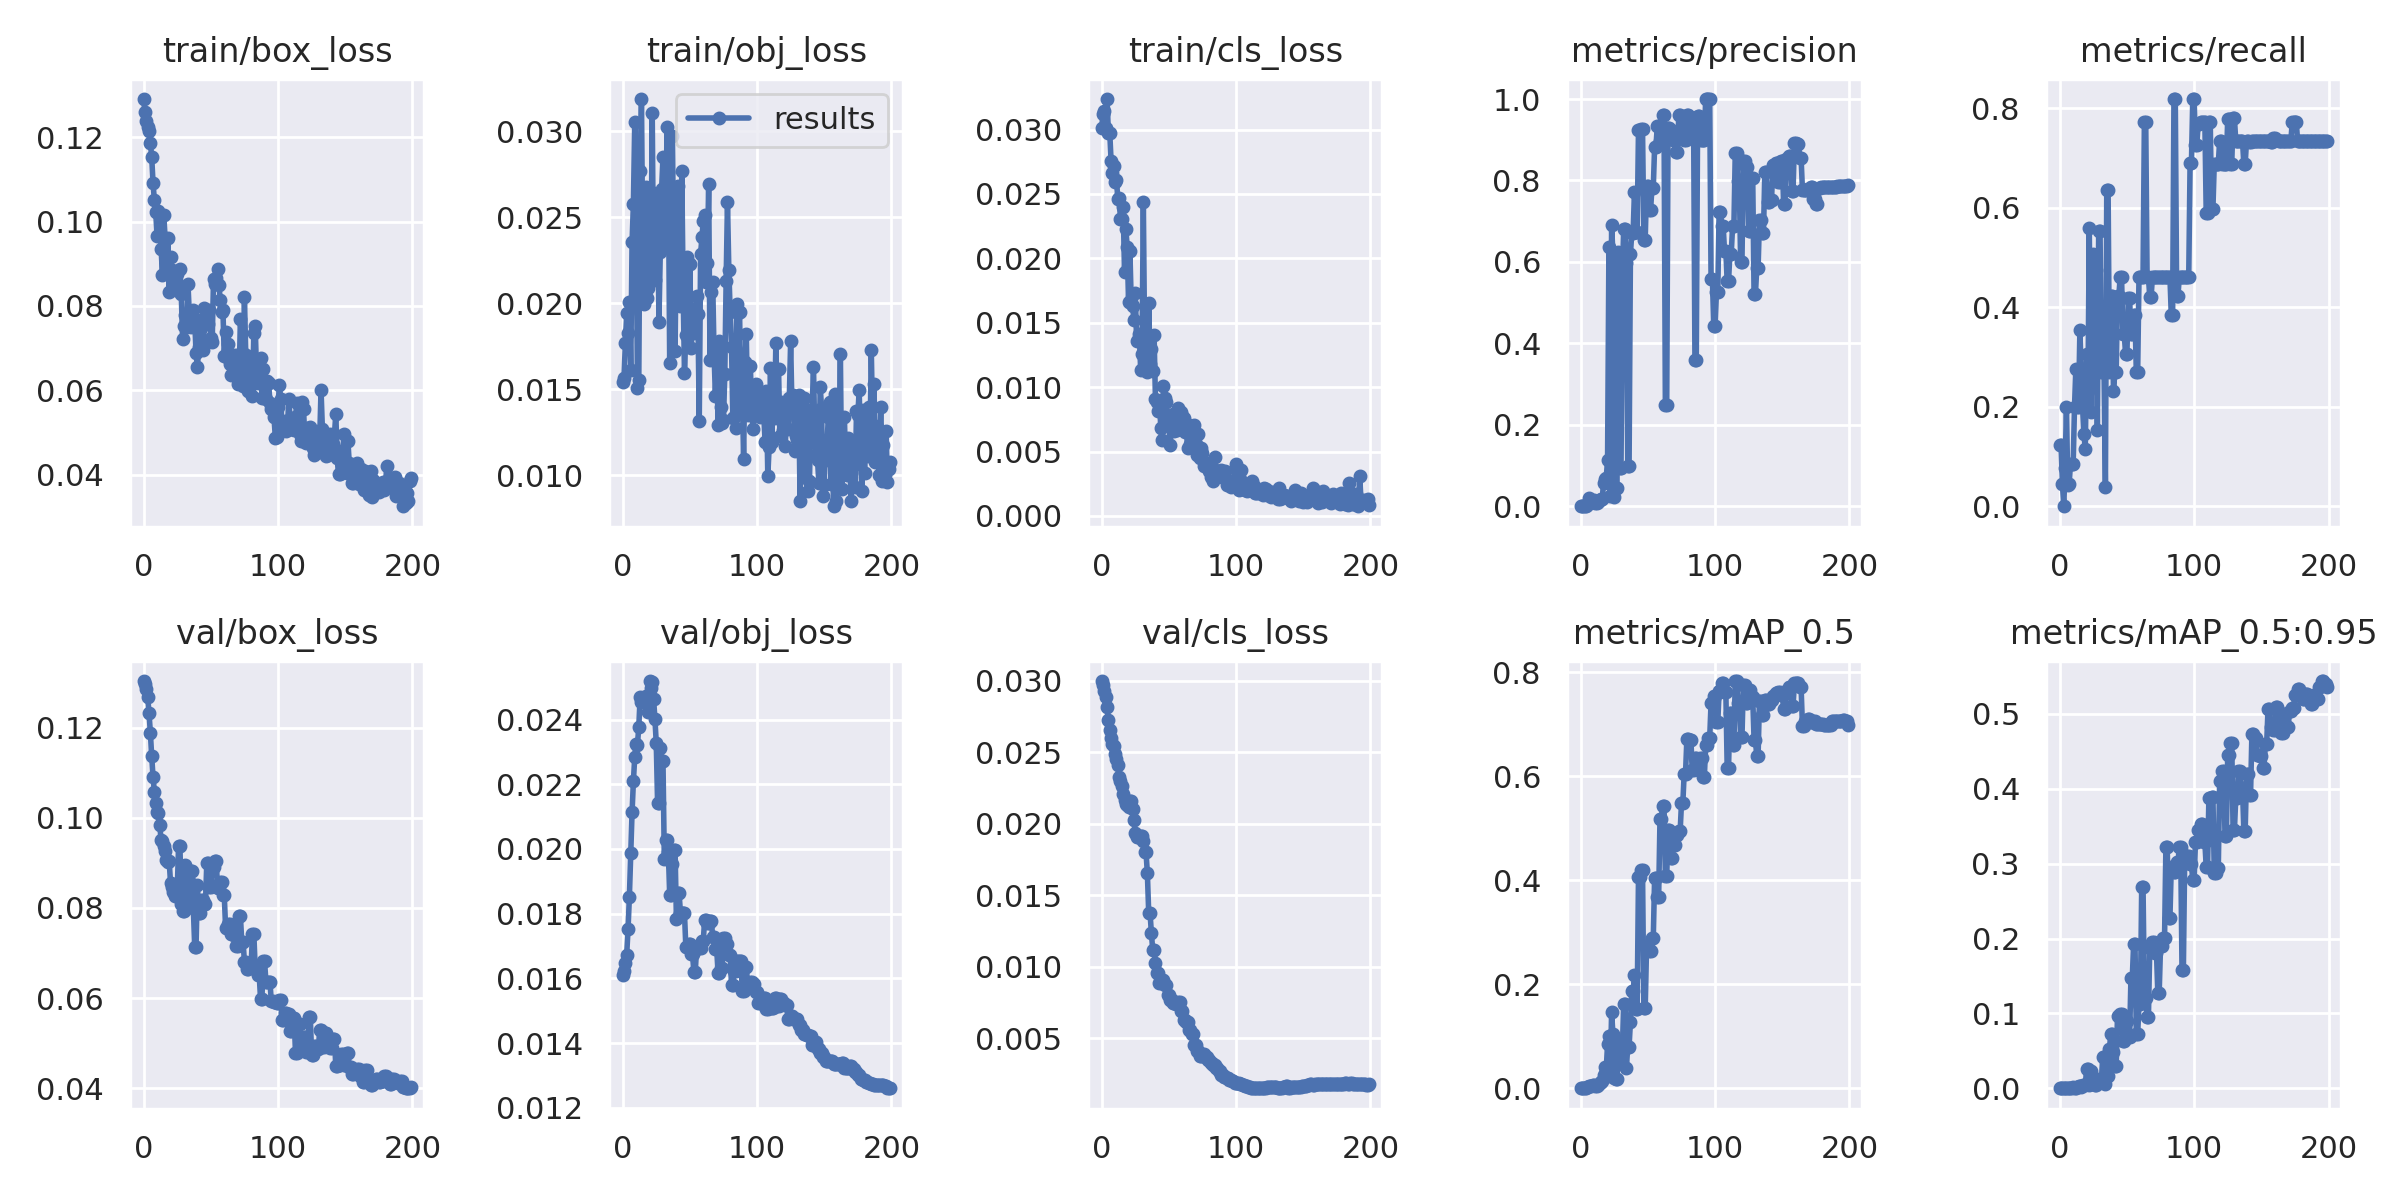

In [12]:
Image('/content/yolov5/runs/train/exp/results.png')

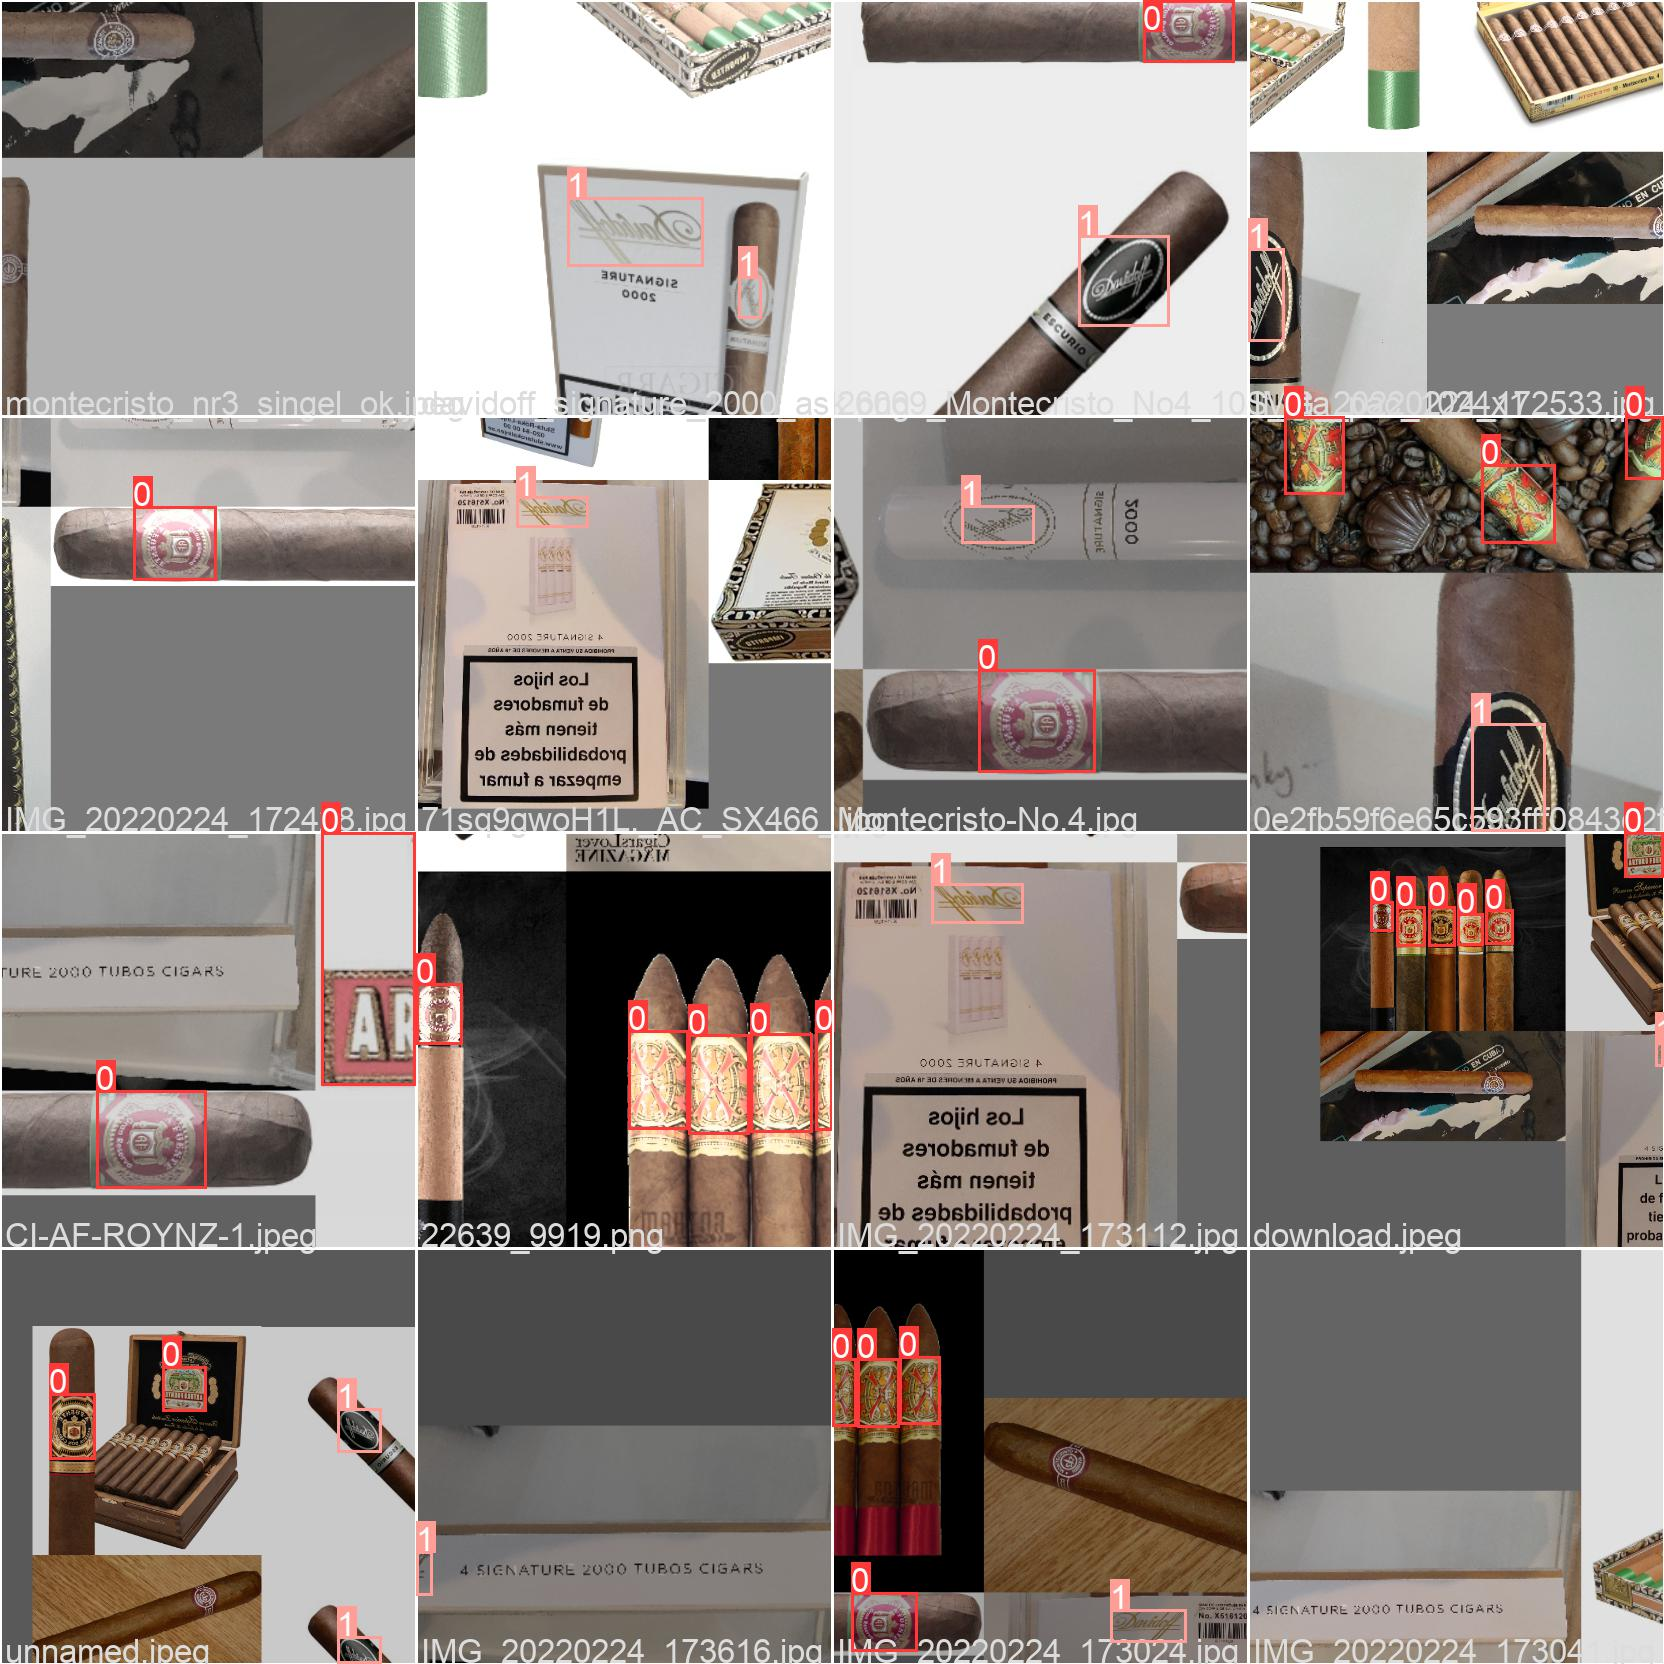

In [13]:
Image('/content/yolov5/runs/train/exp/train_batch0.jpg')

**Performing detection using weights trained during custom model training**

In [15]:
!python detect.py --source /content/drive/MyDrive/custom_dataset/logos_dataset/images/valid/IMG_20220224_172356.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/custom_dataset/logos_dataset/images/valid/IMG_20220224_172356.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-167-g488fb0a torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/custom_dataset/logos_dataset/images/valid/IMG_20220224_172356.jpg: 640x640 3 new_logos, Done. (0.033s)
Speed: 0.7ms pre-process, 32.9ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3
